# **Import needed libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
import requests
from urllib.parse import urlparse

# **Import Dataset**

In [2]:
df = pd.read_csv(filepath_or_buffer='phishing_site_urls.csv', header=0)
len(df)

549346

Data preparation
- Get Top-Level-Domain
- Get Length of Domain
- Get Amount Characters of Domain
- Get Amount of Numbers of Domain
- Get Amount of special characters of Domain
- Get IP-Address
- Get External Score
- Get Length of URL
- Get Amount of .
- Get Amount of /
- Get Amount Characters of URL
- Get Amount of Numbers of URL
- Get Amount of special characters of URL
- Get if a IP-Address is included in the URL
- Get Amount of Subdomains
- Get Length of Subdomain-Part
- Get Amount of directories
- Get Length of directory-part
- Get if URL was shortened
- Get if URL redirects
- Get Buzzwords in URL -> create Wordcloud

Unshorten URLs

new_column = []    
for values in df['URL']:
    if not re.match(r'^((http|https)://)', values):
        new_column.append("http://"+values)
    else:
        new_column.append(values)

df['http_domain'] = new_column

**Check which URLs are still working**

In [7]:
def is_working(url):
    try:
        response = requests.get(url)
        return response.status_code == 200
    except:
        return False

In [8]:
df['is_working'] = df['URL'].apply(is_working)
df.head(15)

,URL,Label,is_working
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,False
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,False
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,False
3,mail.printakid.com/www.online.americanexpress....,bad,False
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,False
5,smilesvoegol.servebbs.org/voegol.php,bad,False
6,premierpaymentprocessing.com/includes/boleto-2...,bad,False
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,bad,False
8,super1000.info/docs,bad,False
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,bad,False


In [12]:
df_groupBy_isWorking = df.groupby(by=['Label', 'is_working'],as_index = False).count()
df_groupBy_isWorking.head(10)
print(df[df['is_working']])

                                                      URL Label  is_working
100555        http://www.ogrob.org/240972,81/index22.html   bad        True
108725  http://bazurashop.com/idex.html?sfm_from_ifram...   bad        True
109232  http://spaziovan.com/login/f3a779bd43f870c436e...   bad        True
115415  https://www.google.com/url?sa=t&rct=j&q=&esrc=...   bad        True
126131  https://www.google.com/url?sa=t&rct=j&q=&esrc=...   bad        True
129165  https://plus.google.com/share?title=FerienWohn...   bad        True
129748  http://cthrp.com.br/painel/plugins/magicline/M...   bad        True
132574  https://www.google.es/url?sa=t&amp;rct=j&amp;q...   bad        True
134946  http://www.google.ru/url?sa=t&rct=j&q=&esrc=s&...   bad        True


Checked the working URL -> indeed these URLs are suspicious 
Unfortunatly only small amount of URLs are working -> cannot find URLs that redirect + IP-addresses + shortened URLs + no external score

**Delete all rows that contain IP-addresses from main dataframe and consider them separatly**

In [4]:
ip_regex = re.compile(r'\b(?:\d{1,3}\.){3}\d{1,3}\b')


df_ip = df.loc[df['URL'].str.match(ip_regex)]
#df_ip = df_ip.drop('is_working', axis=1)
df_ip_groupBy_label = df_ip.groupby(by=['Label'],as_index = False).count()
amount_ip_addresses = df_ip_groupBy_label['URL'].sum()
df_ip_groupBy_label['Percentage'] = (df_ip_groupBy_label['URL'] / amount_ip_addresses) * 100

df_ip_groupBy_label.head(15)

,Label,URL,Percentage
0,bad,7823,99.668748
1,good,26,0.331252


The numbers show, that if a URL is including an IP-address it is very likely that the URL is malicious. Within the dataset 99,67% of all URLs that include an IP-address are malicious.

**General Distribution of Bad vs Good URLs**

In [5]:
df_groupBy_label = df.groupby(by=['Label'],as_index = False).count()
df_groupBy_label.head(10)
#Pie or Bar Chart

,Label,URL
0,bad,156422
1,good,392924


**Get Domain of every URL**

In [6]:
new_column = []    
for values in df['URL']:
    new_column.append(re.search(r'^((http|https)://)?[^(/|\s|:]*', values).group())

df['domain'] = new_column

**Get TLD of every URL -> if not possible to allocate delete the row**

In [7]:
new_column = []    
i = 1
for values in df['domain']:
    try:
        new_column.append(re.search(r'(?<=\.)[a-z]+(?=\/|$)', values).group())
    except:
        new_column.append("n/a")

df['tld'] = new_column

In [8]:
#Delete rows where a TLD cannot be calculated
na_rows = df.loc[df['tld'] == 'n/a']
df = df.drop(na_rows.index)

In [9]:
df_tld = df
df_tld['tld_count'] = df_tld['tld']
df_tld_groupBy_label_tld = df_tld.groupby(by=['tld', 'Label'],as_index = False).count()
amount_tld = df_tld_groupBy_label_tld['tld_count'].sum()
df_tld_pivot_label_tld = df_tld_groupBy_label_tld.pivot_table('tld_count', ['tld'], 'Label')
df_tld_pivot_label_tld['bad'] = df_tld_pivot_label_tld['bad'].fillna(0)
df_tld_pivot_label_tld['good'] = df_tld_pivot_label_tld['good'].fillna(0)
df_tld_pivot_label_tld['bad_percentage'] = (df_tld_pivot_label_tld['bad'] / (df_tld_pivot_label_tld['bad'] + df_tld_pivot_label_tld['good'])) * 100
df_tld_pivot_label_tld['overall_percentage'] = ((df_tld_pivot_label_tld['bad'] + df_tld_pivot_label_tld['good']) / amount_tld ) * 100

df_tld_pivot_label_tld = df_tld_pivot_label_tld.sort_values(by='overall_percentage', ascending=False)

df_tld_pivot_label_tld.head(20)

Label,bad,good,bad_percentage,overall_percentage
tld,,,,
com,71804.0,290219.0,19.834099,66.930984
org,5874.0,42897.0,12.044043,9.016806
net,9000.0,14540.0,38.232795,4.352086
ca,906.0,9989.0,8.315741,2.014273
edu,24.0,10062.0,0.237954,1.864704
uk,2126.0,6398.0,24.941342,1.575921
ru,5948.0,247.0,96.012914,1.145335
info,3179.0,1249.0,71.793135,0.818651
br,4025.0,106.0,97.434035,0.763741


Some TLDs do have a high percentage of bad urls in comparison to others -> reasons for that could be costs of tlds -> further investigation for the top 20 tlds used -> comparison of prices hard

**Get length of URL**

In [10]:
new_column = []    
for values in df['URL']:
    new_column.append(len(values))

df['length'] = new_column

**Get Amount of '.'**

In [11]:
new_column = []    
for values in df['URL']:
    new_column.append(values.count("."))

df['amount_dots'] = new_column

**Get Amount of '/'**

In [12]:
new_column = []    
for values in df['URL']:
    new_column.append(values.count("/"))

df['amount_slash'] = new_column

**Get Amount of '#'**

In [13]:
new_column = []    
for values in df['URL']:
    new_column.append(values.count("="))

df['amount_same'] = new_column

**Get amount of '@'**

In [14]:
new_column = []    
for values in df['URL']:
    new_column.append(values.count("@"))

df['amount_at'] = new_column

**Get amount of '-'**

In [15]:
new_column = []    
for values in df['URL']:
    new_column.append(values.count("-"))

df['amount_hypthon'] = new_column

**Get amount of subdomains**

In [16]:
new_column = []    
for values in df['domain']:
    subdomains = values.split(".")[:-2] 
    new_column.append(len(subdomains))

df['amount_subdomains'] = new_column

**Get amount of directories**

In [17]:
new_column = []    
for values in df['URL']:
    new_column.append(len(urlparse(values).path.split('/')) - 1)

df['amount_directories'] = new_column


In [18]:
df.head(15)

,URL,Label,domain,tld,tld_count,length,amount_dots,amount_slash,amount_same,amount_at,amount_hypthon,amount_subdomains,amount_directories
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,nobell.it,it,it,225,6,10,4,0,4,0,8
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,www.dghjdgf.com,com,com,81,5,4,2,0,2,1,4
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,serviciosbys.com,com,com,177,7,11,0,0,1,0,11
3,mail.printakid.com/www.online.americanexpress....,bad,mail.printakid.com,com,com,60,6,2,0,0,0,1,2
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,thewhiskeydregs.com,com,com,116,1,10,0,0,1,0,7
5,smilesvoegol.servebbs.org/voegol.php,bad,smilesvoegol.servebbs.org,org,org,36,3,1,0,0,0,1,1
6,premierpaymentprocessing.com/includes/boleto-2...,bad,premierpaymentprocessing.com,com,com,61,2,2,0,0,3,0,2
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,bad,myxxxcollection.com,com,com,60,5,6,0,0,0,0,6
8,super1000.info/docs,bad,super1000.info,info,info,19,1,1,0,0,0,0,1
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,bad,horizonsgallery.com,com,com,193,4,10,3,0,3,0,10


In [38]:
df.groupby('Label').describe()

length                                                       \
          count       mean        std  min   25%   50%   75%     max   
Label                                                                  
bad    148076.0  65.059976  73.328819  6.0  27.0  42.0  74.0  2307.0   
good   392814.0  45.761455  24.611043  6.0  30.0  40.0  56.0  1025.0   

      amount_dots            ... amount_subdomains       amount_directories  \
            count      mean  ...               75%   max              count   
Label                        ...                                              
bad      148076.0  2.730301  ...               1.0  33.0           148076.0   
good     392814.0  1.782022  ...               1.0   7.0           392814.0   

                                                     
           mean       std  min  25%  50%  75%   max  
Label                                                
bad    2.626030  1.921570  0.0  1.0  2.0  3.0  34.0  
good   2.318102  1.318392  0.0  1.0  2.0  3.0  19.0  

[2 rows x 64 columns]

In [20]:
new_column = []    
for values in df['Label']:
    if values == 'bad':
        new_column.append(0)
    else:
        new_column.append(1)

df['numeric_label'] = new_column


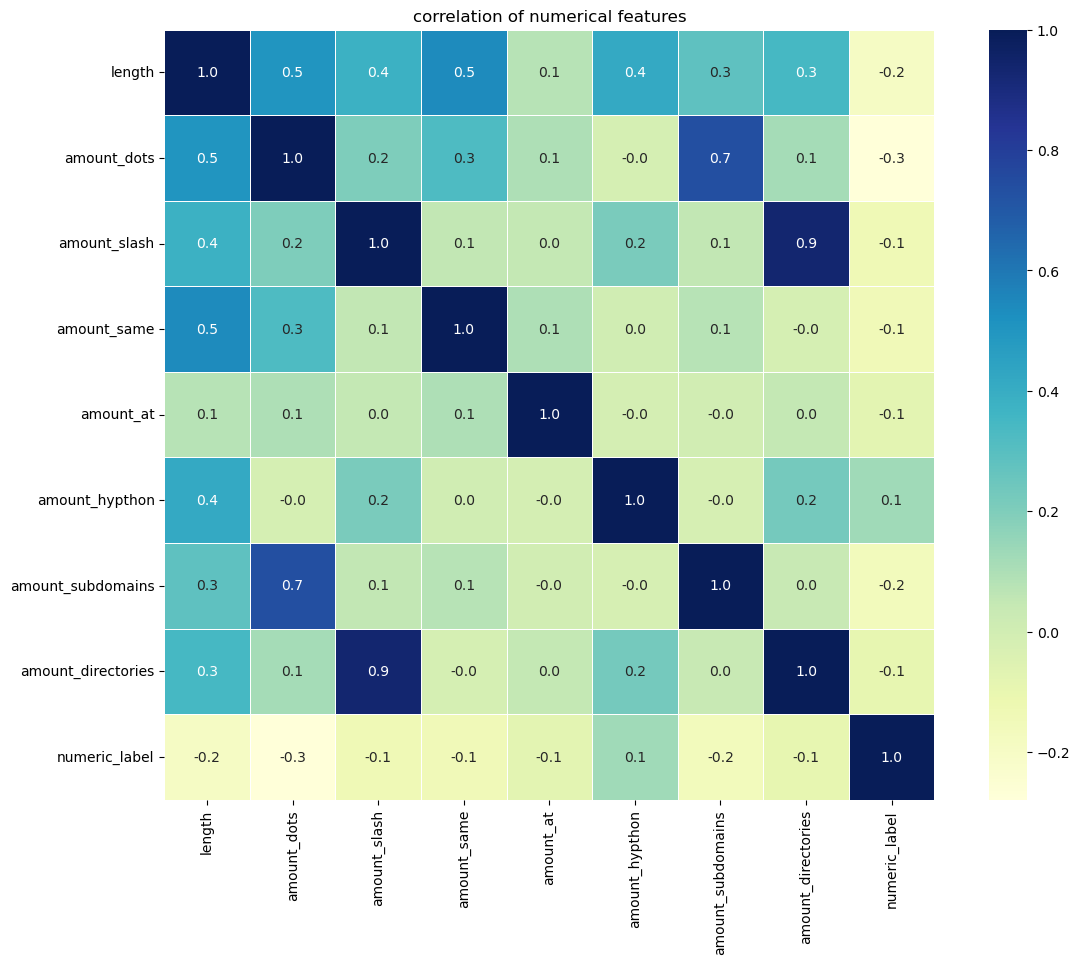

In [21]:
plt.figure(figsize = (14, 10))
sns.heatmap(df.corr(), vmax = 1, linewidths = 0.5, fmt= '.1f',
            square = True, annot = True, cmap = 'YlGnBu', linecolor = "white")
plt.title('correlation of numerical features');

In [4]:
df2 = pd.read_csv(filepath_or_buffer='Phishing_Legitimate_full.csv', header=0)
len(df2)

10000

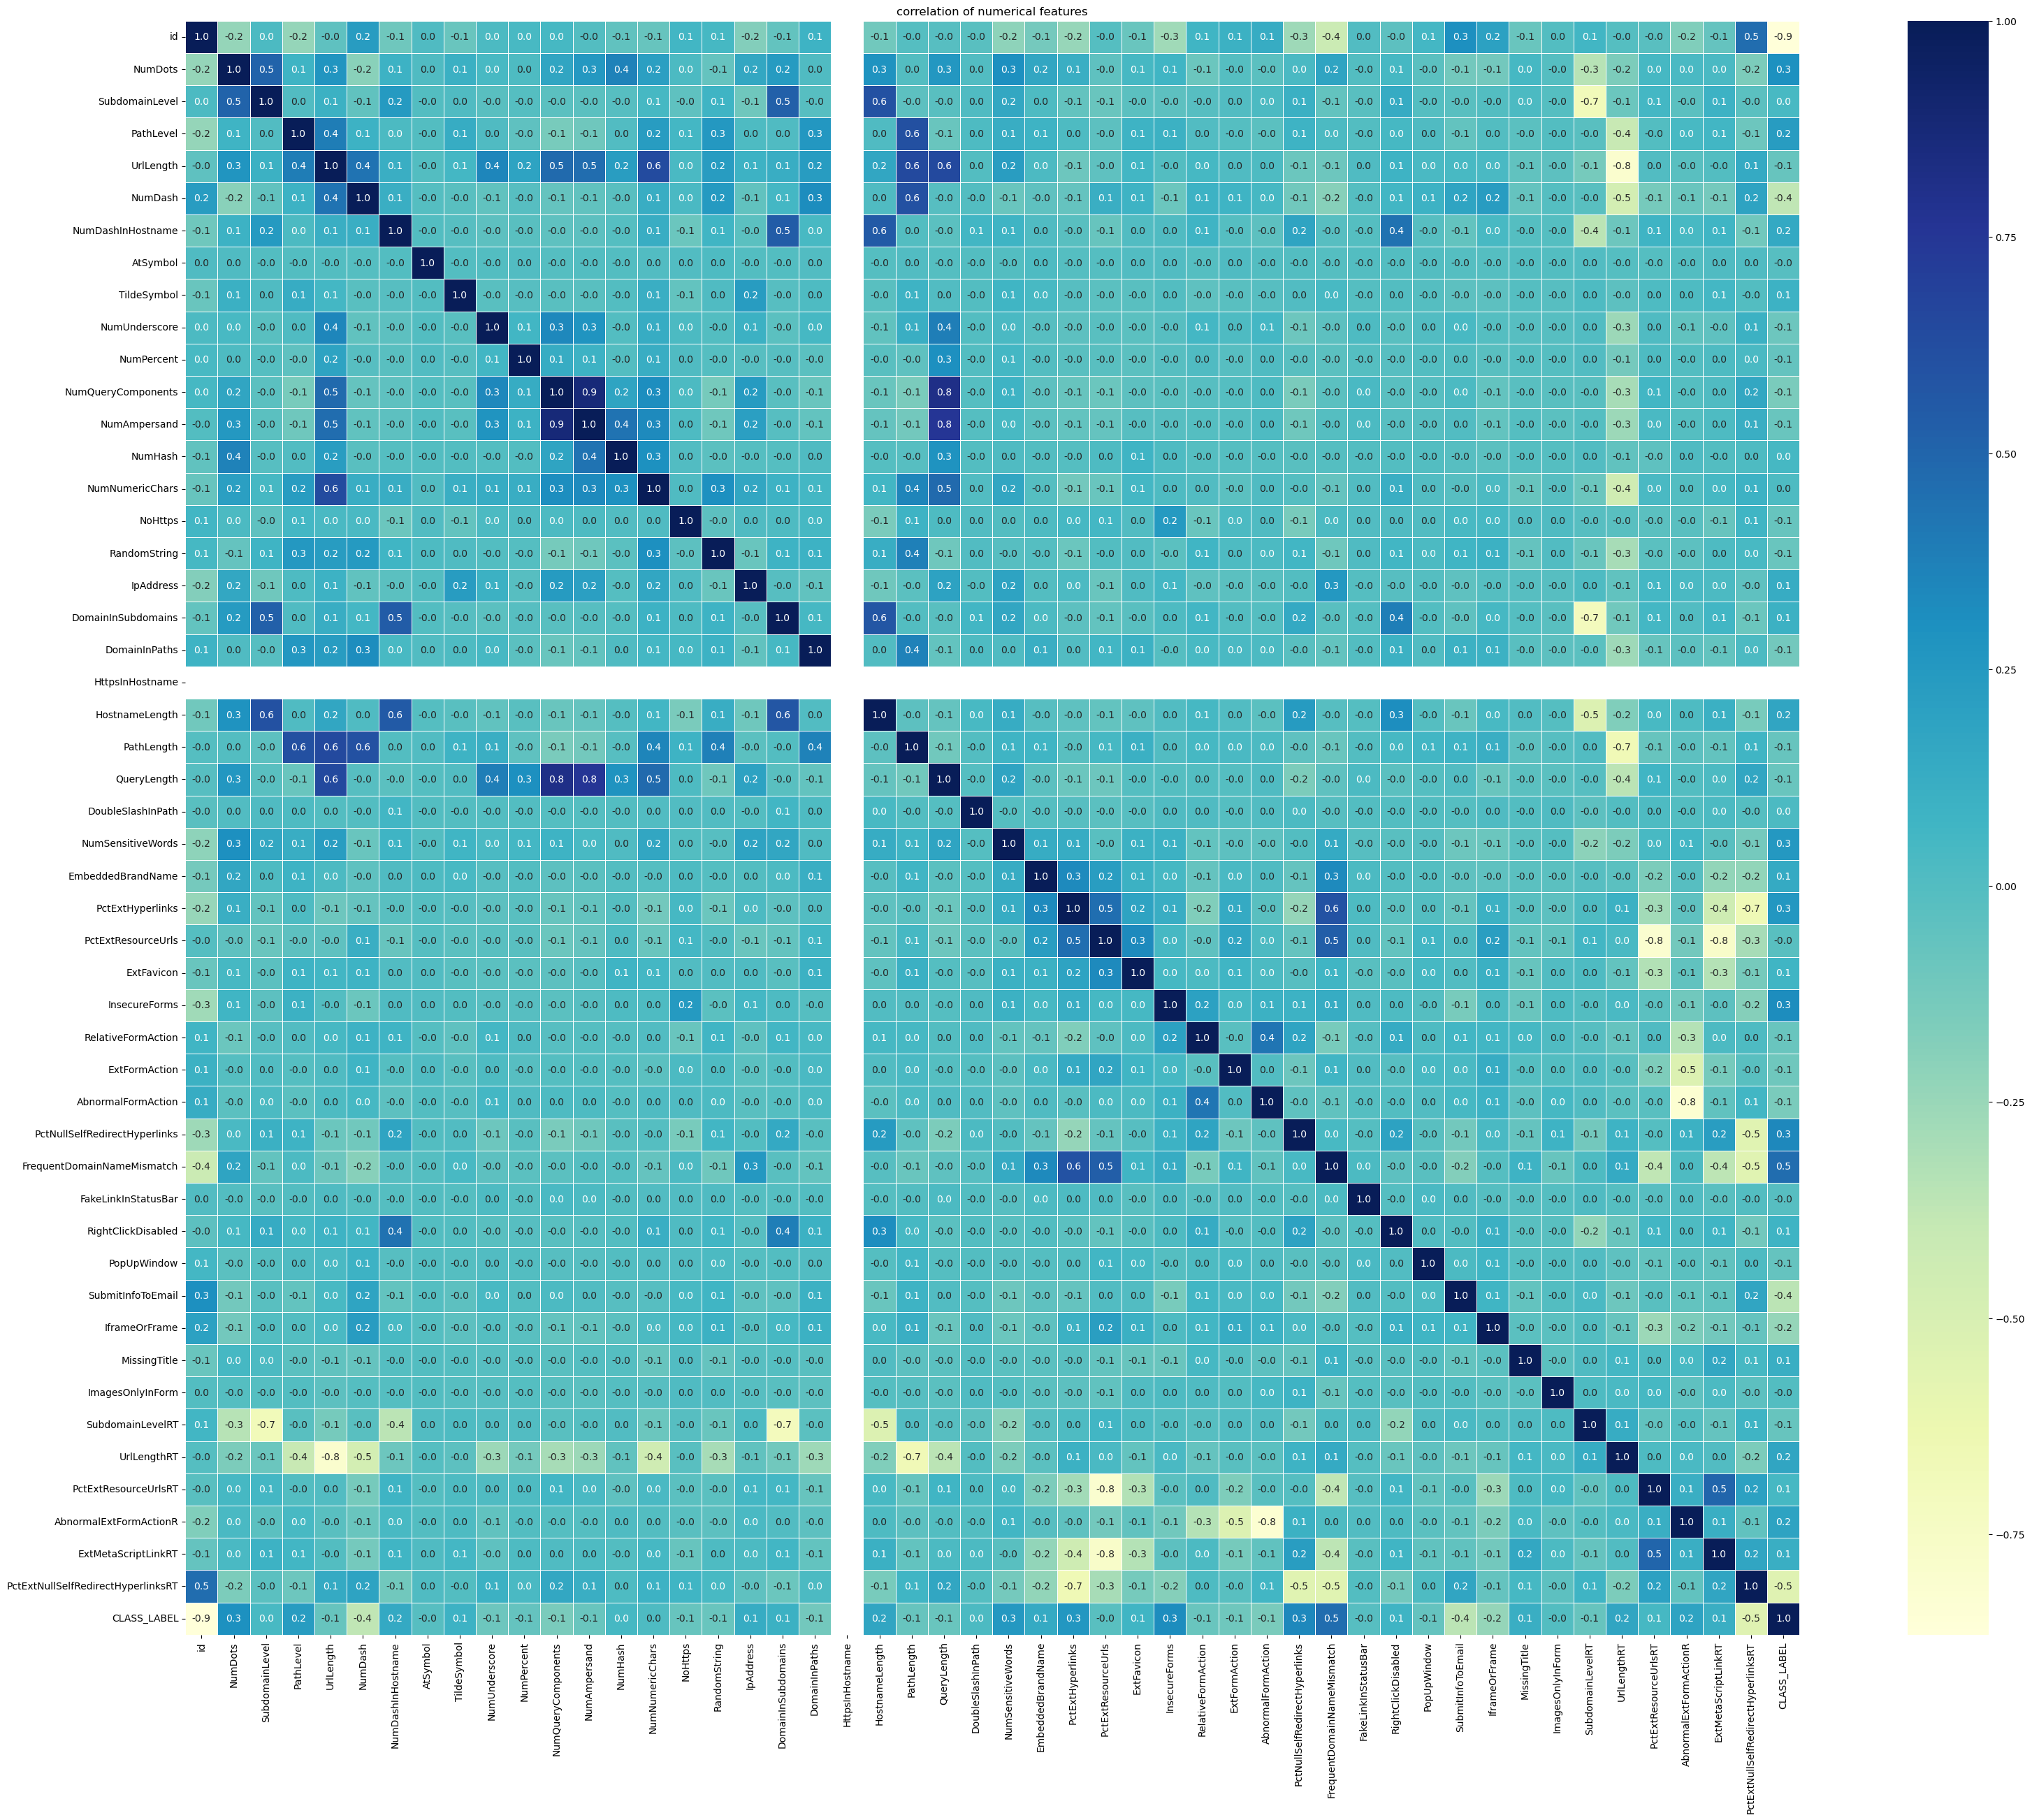

In [8]:
plt.figure(figsize = (40, 30))
sns.heatmap(df2.corr(), vmax = 1, linewidths = 0.5, fmt= '.1f',
            square = True, annot = True, cmap = 'YlGnBu', linecolor = "white")
plt.title('correlation of numerical features');